IMPORTING ALL LIBRARIES

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input,Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

UNZIPPING DATA SET TO DRIVE

In [ ]:
import os
import zipfile


def extract_file(file_path, extract_to):
    if not os.path.exists(file_path):
        print(f'The file {file_path} does not exist.')
        return

    if file_path.endswith('.zip'):
        try:
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f'Successfully unzipped {file_path} to {extract_to}')
        except zipfile.BadZipFile as e:
            print(f'Failed to unzip {file_path}: {e}')
    elif file_path.endswith('.rar'):
        try:
            with rarfile.RarFile(file_path, 'r') as rar_ref:
                rar_ref.extractall(extract_to)
            print(f'Successfully extracted {file_path} to {extract_to}')
        except rarfile.Error as e:
            print(f'Failed to extract {file_path}: {e}')
    else:
        print(f'Unsupported file type: {file_path}')

zip_file_path = '/content/drive/MyDrive/cleaned_dataset.zip'
extract_path = '/content/'

extract_file(zip_file_path, extract_path)


Successfully unzipped /content/drive/MyDrive/cleaned_dataset.zip to /content/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


SETTING PARAMETER FOR THE DATSET AND MODEL

In [ ]:
# Parameters for the dataset and model
img_shape = (256, 256, 3)  # Shape of the input images
num_classes = 4  # Number of classes for classification
batch_size = 32  # Batch size for training
train_path = '/content/cleaned_dataset/train'  # Path to training data
val_path = '/content/cleaned_dataset/val'  # Path to validation data
test_path = '/content/cleaned_dataset/test'  # Path to test data
classes = ['0Normal',  '2Mild', '3Moderate', '4Severe']  # Class labels

In [ ]:
import os
import shutil

def remove_class(directory, class_to_remove):
    class_path = os.path.join(directory, class_to_remove)
    if os.path.exists(class_path):
        shutil.rmtree(class_path)
        print(f'Removed {class_path}')
    else:
        print(f'{class_path} does not exist')

# Directories containing the dataset
train_path = '/content/cleaned_dataset/train'
val_path = '/content/cleaned_dataset/val'
test_path = '/content/cleaned_dataset/test'

# Class to be removed
class_to_remove = '1Doubtful'

# Remove the class from training, validation, and test sets
remove_class(train_path, class_to_remove)
remove_class(val_path, class_to_remove)
remove_class(test_path, class_to_remove)


Removed /content/cleaned_dataset/train/1Doubtful
Removed /content/cleaned_dataset/val/1Doubtful
Removed /content/cleaned_dataset/test/1Doubtful


Image Loading and Preprocessing Function

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(img_path, target_size=img_shape):
    """
    Load an image from the specified path and preprocess it.

    Parameters:
    img_path (str): Path to the image file.
    target_size (tuple): Target size to resize the image (height, width, channels).

    Returns:
    numpy.ndarray or None: Preprocessed image array, or None if an error occurs.
    """
    try:
        # Load the image with the specified target size and RGB color mode
        img = load_img(img_path, color_mode='rgb', target_size=(target_size[0], target_size[1]))

        # Convert the image to a numpy array
        img_array = img_to_array(img)

        # Normalize the pixel values to be between 0 and 1
        img_array /= 255.0

        return img_array
    except Exception as e:
        # Print an error message if the image cannot be loaded or processed
        print(f"Error loading image {img_path}: {str(e)}")
        return None


Image Batch Generator with Preprocessing and One-Hot Encoding

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def generator_fn(image_paths, labels, batch_size=32):
    """
    Generator function to yield batches of preprocessed images and their one-hot encoded labels.

    Parameters:
    image_paths (list): List of file paths to the images.
    labels (list): List of labels corresponding to the images.
    batch_size (int): Number of samples per batch.

    Yields:
    tuple: A batch of preprocessed images and their one-hot encoded labels.
    """
    num_samples = len(image_paths)  # Total number of samples

    while True:  # Infinite loop to keep yielding batches
        # Randomly select indices for the current batch
        indices = np.random.choice(num_samples, batch_size, replace=False)

        # Get the image paths and labels for the current batch
        batch_image_paths = [image_paths[i] for i in indices]
        batch_labels = [labels[i] for i in indices]

        # Load and preprocess the batch of images
        batch_images = [load_and_preprocess_image(img_path) for img_path in batch_image_paths]

        # Filter out any images that failed to load
        batch_images = [img for img in batch_images if img is not None]

        # If all images failed to load, skip the batch
        if not batch_images:
            continue

        # One-hot encode the labels
        batch_labels_one_hot = to_categorical(batch_labels, num_classes)

        # Ensure the batch size matches the specified batch_size
        if len(batch_images) < batch_size:
            # Calculate how many more samples are needed
            extra_samples = batch_size - len(batch_images)

            # Randomly select additional indices for the extra samples
            extra_indices = np.random.choice(num_samples, extra_samples, replace=False)

            # Get the image paths and labels for the extra samples
            extra_batch_image_paths = [image_paths[i] for i in extra_indices]
            extra_batch_labels = [labels[i] for i in extra_indices]

            # Load and preprocess the extra batch of images
            extra_batch_images = [load_and_preprocess_image(img_path) for img_path in extra_batch_image_paths]

            # Filter out any extra images that failed to load
            extra_batch_images = [img for img in extra_batch_images if img is not None]

            # Extend the current batch with the extra images and labels
            batch_images.extend(extra_batch_images)
            batch_labels.extend(extra_batch_labels)

        # Yield the batch of images and their one-hot encoded labels as numpy arrays
        yield np.array(batch_images), np.array(batch_labels_one_hot)


Function to Retrieve Image Paths and Labels from Dataset Directory

In [ ]:
import os

def get_image_paths_and_labels(dataset_path, classes):
    """
    Retrieves image file paths and their corresponding labels from the dataset directory.

    Parameters:
    dataset_path (str): Path to the dataset directory.
    classes (list): List of class names.

    Returns:
    tuple: Two lists, one containing image file paths and the other containing corresponding labels.
    """
    image_paths = []  # List to store image file paths
    labels = []  # List to store corresponding labels

    # Iterate over each class and its index (which will be used as the label)
    for label, class_name in enumerate(classes):
        # Construct the path to the current class directory
        class_path = os.path.join(dataset_path, class_name)

        # List all files in the class directory
        for img_name in os.listdir(class_path):
            # Append the full path of the image file to the image_paths list
            image_paths.append(os.path.join(class_path, img_name))

            # Append the label to the labels list
            labels.append(label)

    # Return the lists of image file paths and corresponding labels
    return image_paths, labels


Retrieving Image Paths and Labels for Training, Validation, and Test Datasets

In [ ]:
# Get image paths and labels for the training dataset
train_image_paths, train_labels = get_image_paths_and_labels(train_path, classes)

# Get image paths and labels for the validation dataset
val_image_paths, val_labels = get_image_paths_and_labels(val_path, classes)

# Get image paths and labels for the test dataset
test_image_paths, test_labels = get_image_paths_and_labels(test_path, classes)


Creating Data Generators for Training, Validation, and Test Datasets

In [ ]:
# Create generators for the training dataset
train_generator = generator_fn(train_image_paths, train_labels, batch_size=batch_size)

# Create generators for the validation dataset
val_generator = generator_fn(val_image_paths, val_labels, batch_size=batch_size)

# Create generators for the test dataset
test_generator = generator_fn(test_image_paths, test_labels, batch_size=batch_size)


UNet Model Definition with Intermediate Feature Map Output

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model

def unet(input_size=(256, 256, 3)):
    # Define the input layer
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Intermediate output from the encoder
    intermediate_output = conv3

    # Decoder
    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up3 = concatenate([up3, conv2], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up2 = concatenate([up2, conv1], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer for segmentation map
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    # Convolutional layer to reduce channels to 3 for feature illustration
    reduced_output = Conv2D(3, (1, 1), activation='relu')(intermediate_output)

    # Define the UNet model
    model = Model(inputs=[inputs], outputs=[outputs, reduced_output])
    return model

# Create and return the UNet model


Combining UNet and MobileNet for Segmentation and Classification Tasks

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

def classification_model(input_shape, num_classes, trainable_layers=None):
    # Load the pre-trained MobileNet model without the top classification layer
    base_mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze or unfreeze layers based on the specified list
    if trainable_layers is not None:
        for layer in base_mobilenet.layers:
            if layer.name in trainable_layers:
                layer.trainable = True
            else:
                layer.trainable = False

    # Define the custom classification model architecture
    custom_model = models.Sequential()

    # Add the pre-trained MobileNet base model
    custom_model.add(base_mobilenet)

    # Add custom convolutional layers
    custom_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.1))

    custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    custom_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())

    custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    custom_model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.1))

    custom_model.add(Flatten())
    custom_model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
    custom_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    custom_model.add(Dropout(0.2))
    custom_model.add(Dense(num_classes, activation='softmax'))

    return custom_model

# Create a UNet model
unet_model = unet((256, 256, 3))

# Get the UNet's intermediate output shape
_, reduced_output = unet_model.outputs

# Adjust the shape with 3 channels to match the output from the UNet's intermediate layer
reduced_output_shape = (256, 256, 3)

# Instantiate the classification model
num_classes = 5  # Example number of classes
mobilenet_model = classification_model((256, 256, 3), 5)

# Create the combined model
combined_input = Input(shape=(256, 256, 3))
unet_outputs, unet_reduced_output = unet_model(combined_input)

# Upsample the output of the UNet model to match the input shape expected by MobileNet
upsampled_output = UpSampling2D(size=(4, 4))(unet_reduced_output)  # Upsampling by a factor of 4 to match (64, 64) to (256, 256)

# Ensure the upsampled output has the correct shape for MobileNet
upsampled_output = preprocess_input(upsampled_output)

# Pass the preprocessed output to the MobileNet-based classification model
mobilenet_output = mobilenet_model(upsampled_output)

# Create the combined model with UNet and classification parts
combined_model = Model(inputs=combined_input, outputs=mobilenet_output)
combined_model.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 256), dtype=tf.float32, name=None), name='conv2d_5/Relu:0', description="created by layer 'conv2d_5'")
17225924/17225924 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          [(None, 256, 256, 1),     1863620   
                              (None, 64, 64, 3)]                 
                                                                 
 up_sampling2d (UpSampling2  (None, 256, 256, 3)       0         
 D)                                                              
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                

Training the Combined UNet and MobileNet Model with Callbacks

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import shutil

# Define callbacks for learning rate reduction, early stopping, and model checkpointing
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/model/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
callbacks_list = [checkpoint, lr_reduction, early_stopping]

# Calculate steps per epoch for training and validation
steps_per_epoch_train = len(train_image_paths) // batch_size
steps_per_epoch_val = len(val_image_paths) // batch_size

# Calculate the number of steps for validation
validation_steps = len(val_image_paths) // batch_size

# Compile the combined model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the combined model
history = combined_model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)


Epoch 1/40


253/253 [==============================] - ETA: 0s - loss: 2.0811 - accuracy: 0.5903
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to /model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


253/253 [==============================] - 222s 715ms/step - loss: 2.0811 - accuracy: 0.5903 - val_loss: 1.7434 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/40
253/253 [==============================] - ETA: 0s - loss: 1.2499 - accuracy: 0.6985
Epoch 2: val_accuracy improved from 0.56250 to 0.61111, saving model to /model/best_model.h5
253/253 [==============================] - 177s 702ms/step - loss: 1.2499 - accuracy: 0.6985 - val_loss: 1.6620 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 3/40
253/253 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.7548
Epoch 3: val_accuracy did not improve from 0.61111
253/253 [==============================] - 177s 699ms/step - loss: 0.8828 - accuracy: 0.7548 - val_loss: 1.2677 - val_accuracy: 0.5914 - lr: 0.0010
Epoch 4/40
253/253 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.7751
Epoch 4: val_accuracy did not improve from 0.61111
253/253 [==============================] - 177s 699ms/step - loss: 0.7142

'/content/drive/MyDrive/mobilenetwithout1class'

Saving and Copying the Trained Model to Google Drive

In [ ]:
colab_model_path = '/model/best_model.h5'

# Save the trained model locally
combined_model.save(colab_model_path)

# Define the path for the best model in Google Drive
drive_model_path = '/content/drive/MyDrive/mobilenetwithmodifiedlayerwith4classes'

# Copy the trained model from the local directory to Google Drive
shutil.copy(colab_model_path, drive_model_path)


'/content/drive/MyDrive/mobilenetwithmodifiedlayerwith4classes'

Extracting and Visualizing Training Metrics from Log Text

Epochs: 18
Validation Accuracy: 18
Validation Loss: 18
Accuracy: 36
Loss: 36


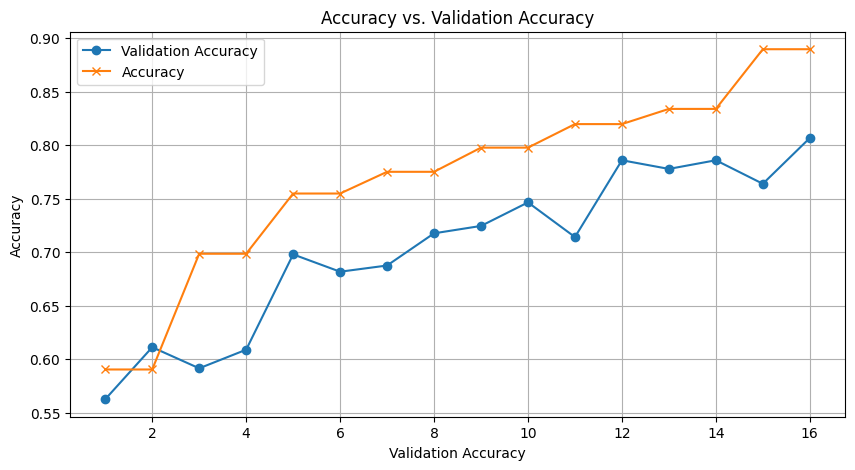

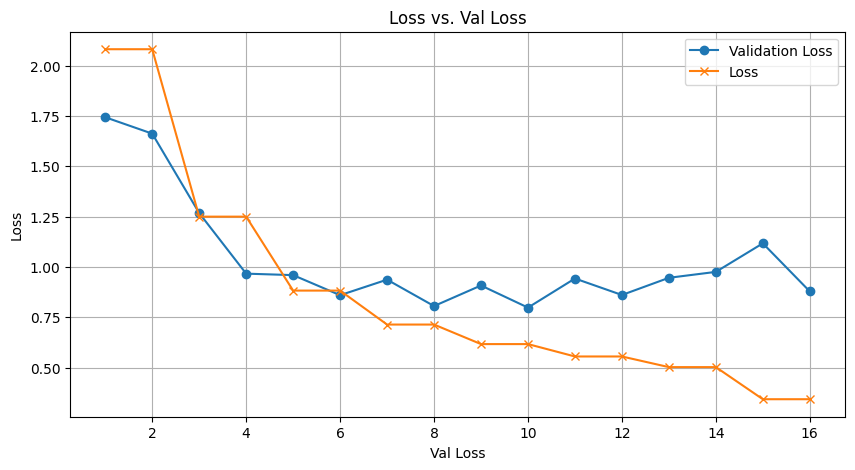

In [ ]:
import re
import matplotlib.pyplot as plt

# Initialize lists to store values
epochs = []
val_accuracy = []
val_loss = []
accuracy = []
loss = []

text="""Epoch 1/40
WARNING:tensorflow:Gradients do not exist for variables ['conv2d_transpose/kernel:0', 'conv2d_transpose/bias:0', 'conv2d_6/kernel:0', 'conv2d_6/bias:0', 'conv2d_7/kernel:0', 'conv2d_7/bias:0', 'conv2d_transpose_1/kernel:0', 'conv2d_transpose_1/bias:0', 'conv2d_8/kernel:0', 'conv2d_8/bias:0', 'conv2d_9/kernel:0', 'conv2d_9/bias:0', 'conv2d_10/kernel:0', 'conv2d_10/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
WARNING:tensorflow:Gradients do not exist for variables ['conv2d_transpose/kernel:0', 'conv2d_transpose/bias:0', 'conv2d_6/kernel:0', 'conv2d_6/bias:0', 'conv2d_7/kernel:0', 'conv2d_7/bias:0', 'conv2d_transpose_1/kernel:0', 'conv2d_transpose_1/bias:0', 'conv2d_8/kernel:0', 'conv2d_8/bias:0', 'conv2d_9/kernel:0', 'conv2d_9/bias:0', 'conv2d_10/kernel:0', 'conv2d_10/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
WARNING:tensorflow:Gradients do not exist for variables ['conv2d_transpose/kernel:0', 'conv2d_transpose/bias:0', 'conv2d_6/kernel:0', 'conv2d_6/bias:0', 'conv2d_7/kernel:0', 'conv2d_7/bias:0', 'conv2d_transpose_1/kernel:0', 'conv2d_transpose_1/bias:0', 'conv2d_8/kernel:0', 'conv2d_8/bias:0', 'conv2d_9/kernel:0', 'conv2d_9/bias:0', 'conv2d_10/kernel:0', 'conv2d_10/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
WARNING:tensorflow:Gradients do not exist for variables ['conv2d_transpose/kernel:0', 'conv2d_transpose/bias:0', 'conv2d_6/kernel:0', 'conv2d_6/bias:0', 'conv2d_7/kernel:0', 'conv2d_7/bias:0', 'conv2d_transpose_1/kernel:0', 'conv2d_transpose_1/bias:0', 'conv2d_8/kernel:0', 'conv2d_8/bias:0', 'conv2d_9/kernel:0', 'conv2d_9/bias:0', 'conv2d_10/kernel:0', 'conv2d_10/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss` argument?
253/253 [==============================] - ETA: 0s - loss: 2.0811 - accuracy: 0.5903
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to /model/best_model.h5
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
253/253 [==============================] - 222s 715ms/step - loss: 2.0811 - accuracy: 0.5903 - val_loss: 1.7434 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/40
253/253 [==============================] - ETA: 0s - loss: 1.2499 - accuracy: 0.6985
Epoch 2: val_accuracy improved from 0.56250 to 0.61111, saving model to /model/best_model.h5
253/253 [==============================] - 177s 702ms/step - loss: 1.2499 - accuracy: 0.6985 - val_loss: 1.6620 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 3/40
253/253 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.7548
Epoch 3: val_accuracy did not improve from 0.61111
253/253 [==============================] - 177s 699ms/step - loss: 0.8828 - accuracy: 0.7548 - val_loss: 1.2677 - val_accuracy: 0.5914 - lr: 0.0010
Epoch 4/40
253/253 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.7751
Epoch 4: val_accuracy did not improve from 0.61111
253/253 [==============================] - 177s 699ms/step - loss: 0.7142 - accuracy: 0.7751 - val_loss: 0.9669 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 5/40
253/253 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.7977
Epoch 5: val_accuracy improved from 0.61111 to 0.69792, saving model to /model/best_model.h5
253/253 [==============================] - 177s 699ms/step - loss: 0.6172 - accuracy: 0.7977 - val_loss: 0.9596 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 6/40
253/253 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.8197
Epoch 6: val_accuracy did not improve from 0.69792
253/253 [==============================] - 176s 697ms/step - loss: 0.5557 - accuracy: 0.8197 - val_loss: 0.8600 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 7/40
253/253 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.8339
Epoch 7: val_accuracy did not improve from 0.69792

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
253/253 [==============================] - 176s 698ms/step - loss: 0.5029 - accuracy: 0.8339 - val_loss: 0.9371 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 8/40
253/253 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8897
Epoch 8: val_accuracy improved from 0.69792 to 0.71759, saving model to /model/best_model.h5
253/253 [==============================] - 176s 697ms/step - loss: 0.3435 - accuracy: 0.8897 - val_loss: 0.8060 - val_accuracy: 0.7176 - lr: 5.0000e-04
Epoch 9/40
253/253 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.9177
Epoch 9: val_accuracy improved from 0.71759 to 0.72454, saving model to /model/best_model.h5

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
253/253 [==============================] - 176s 695ms/step - loss: 0.2738 - accuracy: 0.9177 - val_loss: 0.9082 - val_accuracy: 0.7245 - lr: 5.0000e-04
Epoch 10/40
253/253 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9453
Epoch 10: val_accuracy improved from 0.72454 to 0.74653, saving model to /model/best_model.h5
253/253 [==============================] - 177s 699ms/step - loss: 0.1905 - accuracy: 0.9453 - val_loss: 0.7983 - val_accuracy: 0.7465 - lr: 2.5000e-04
Epoch 11/40
253/253 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9592
Epoch 11: val_accuracy did not improve from 0.74653

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
253/253 [==============================] - 176s 697ms/step - loss: 0.1621 - accuracy: 0.9592 - val_loss: 0.9428 - val_accuracy: 0.7141 - lr: 2.5000e-04
Epoch 12/40
253/253 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9774
Epoch 12: val_accuracy improved from 0.74653 to 0.78588, saving model to /model/best_model.h5

Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
253/253 [==============================] - 176s 698ms/step - loss: 0.1035 - accuracy: 0.9774 - val_loss: 0.8610 - val_accuracy: 0.7859 - lr: 1.2500e-04
Epoch 13/40
253/253 [==============================] - ETA: 0s - loss: 0.0796 - accuracy: 0.9855
Epoch 13: val_accuracy did not improve from 0.78588

Epoch 13: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
253/253 [==============================] - 175s 693ms/step - loss: 0.0796 - accuracy: 0.9855 - val_loss: 0.9463 - val_accuracy: 0.7778 - lr: 6.2500e-05
Epoch 14/40
253/253 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9902
Epoch 14: val_accuracy did not improve from 0.78588

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
253/253 [==============================] - 175s 692ms/step - loss: 0.0631 - accuracy: 0.9902 - val_loss: 0.9757 - val_accuracy: 0.7859 - lr: 3.1250e-05
Epoch 15/40
253/253 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9932
Epoch 15: val_accuracy did not improve from 0.78588

Epoch 15: ReduceLROnPlateau reducing learning rate to 1e-05.
253/253 [==============================] - 176s 696ms/step - loss: 0.0571 - accuracy: 0.9932 - val_loss: 1.1174 - val_accuracy: 0.7639 - lr: 1.5625e-05
Epoch 16/40
253/253 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9925
Epoch 16: val_accuracy improved from 0.78588 to 0.80671, saving model to /model/best_model.h5
253/253 [==============================] - 177s 698ms/step - loss: 0.0597 - accuracy: 0.9925 - val_loss: 0.8787 - val_accuracy: 0.8067 - lr: 1.0000e-05
Epoch 17/40
253/253 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9949
Epoch 17: val_accuracy did not improve from 0.80671
253/253 [==============================] - 176s 696ms/step - loss: 0.0538 - accuracy: 0.9949 - val_loss: 0.9336 - val_accuracy: 0.8044 - lr: 1.0000e-05
Epoch 18/40
253/253 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9941
Epoch 18: val_accuracy did not improve from 0.80671
Restoring model weights from the end of the best epoch: 10.
253/253 [==============================] - 175s 693ms/step - loss: 0.0534 - accuracy: 0.9941 - val_loss: 1.0668 - val_accuracy: 0.7789 - lr: 1.0000e-05
Epoch 18: early stopping
/content/drive/MyDrive/mobilenetwithout1class"""
# Split the text by lines
lines = text.split('\n')

# Extract data from the logger
for line in lines:
    # Extract epoch number
    epoch_match = re.match(r'Epoch (\d+)/\d+', line)
    if epoch_match:
        epochs.append(int(epoch_match.group(1)))

    # Extract validation accuracy
    val_acc_match = re.search(r'val_accuracy: ([\d.]+)', line)
    if val_acc_match:
        val_accuracy.append(float(val_acc_match.group(1)))

    # Extract validation loss
    val_loss_match = re.search(r'val_loss: ([\d.]+)', line)
    if val_loss_match:
        val_loss.append(float(val_loss_match.group(1)))

    # Extract accuracy
    acc_match = re.search(r'accuracy: ([\d.]+)', line)
    if acc_match:
        accuracy.append(float(acc_match.group(1)))

    # Extract loss
    loss_match = re.search(r'loss: ([\d.]+)', line)
    if loss_match:
        loss.append(float(loss_match.group(1)))

print("Epochs:", len(epochs))
print("Validation Accuracy:", len(val_accuracy))
print("Validation Loss:", len(val_loss))
print("Accuracy:", len(accuracy))
print("Loss:", len(loss))

epochs = epochs[:16]
val_accuracy = val_accuracy[:16]
val_loss = val_loss[:16]
accuracy = accuracy[:16]
loss = loss[:16]

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.plot(epochs, accuracy, label='Accuracy', marker='x')
plt.title('Accuracy vs. Validation Accuracy')
plt.xlabel('Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss (val_loss) and loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.plot(epochs, loss, label='Loss', marker='x')
plt.title('Loss vs. Val Loss')
plt.xlabel('Val Loss')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Generating Predictions and True Labels for Test Set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from keras.models import load_model

# Set image dimensions
img_shape = (256, 256, 3)

# Set the number of classes
num_classes = 5

# Set batch size for generating predictions
batch_size = 32

# Define the paths to your data
train_path = '/content/final_splitted_new_dataset/train'
val_path = '/content/final_splitted_new_dataset/val'
test_path = '/content/final_splitted_new_dataset/test'

# Define the classes
classes = ['0Normal', '2Mild', '3Moderate', '4Severe']

# Create data generators for test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_shape[0], img_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

drive_model_path = '/content/drive/MyDrive/mobilenetwithmodifiedlayerwith4classes'

# Load the model
loaded_model = load_model(drive_model_path)
y_pred=loaded_model.predict_generator(test_generator,steps=len(test_generator),verbose=1)
# Generate predictions on the test set
# y_pred = combined_model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

# Get the true labels of the test set



Found 891 images belonging to 4 classes.


<ipython-input-14-aaf8424ec3f3>:41: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred=loaded_model.predict_generator(test_generator,steps=len(test_generator),verbose=1)


28/28 [==============================] - 12s 374ms/step


Evaluating Model Performance: Confusion Matrix and Classification Report

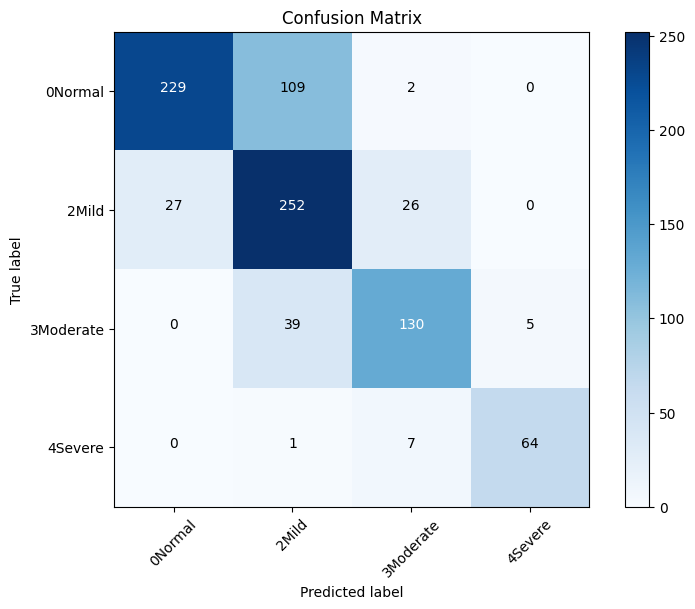

              precision    recall  f1-score   support

     0Normal       0.89      0.67      0.77       340
       2Mild       0.63      0.83      0.71       305
   3Moderate       0.79      0.75      0.77       174
     4Severe       0.93      0.89      0.91        72

    accuracy                           0.76       891
   macro avg       0.81      0.78      0.79       891
weighted avg       0.79      0.76      0.76       891



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_true = test_generator.classes

# Convert predictions from probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Add text annotations to each cell
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_labels, target_names=classes))

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models

def classification_model(input_shape, num_classes, trainable_layers=None):
    # Load the pre-trained MobileNet model without the top classification layer
    base_mobilenet = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze or unfreeze layers based on the specified list
    if trainable_layers is not None:
        for layer in base_mobilenet.layers:
            if layer.name in trainable_layers:
                layer.trainable = True
            else:
                layer.trainable = False

    # Define the custom classification model architecture
    custom_model = models.Sequential()

    # Add the pre-trained MobileNet base model
    custom_model.add(base_mobilenet)

    # Add custom convolutional layers
    custom_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.1))

    custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    custom_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())

    custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    custom_model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.1))

    custom_model.add(Flatten())
    custom_model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
    custom_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    custom_model.add(Dropout(0.2))
    custom_model.add(Dense(num_classes, activation='softmax'))

    return custom_model

# Create a UNet model
unet_model = unet((256, 256, 3))

# Get the UNet's intermediate output shape
_, reduced_output = unet_model.outputs

# Adjust the shape with 3 channels to match the output from the UNet's intermediate layer
reduced_output_shape = (256, 256, 3)

# Instantiate the classification model
num_classes = 4 # Example number of classes
mobilenet_model = classification_model((256, 256, 3), 4)

# Create the combined model
combined_input = Input(shape=(256, 256, 3))
unet_outputs, unet_reduced_output = unet_model(combined_input)

# Upsample the output of the UNet model to match the input shape expected by MobileNet
upsampled_output = UpSampling2D(size=(4, 4))(unet_reduced_output)  # Upsampling by a factor of 4 to match (64, 64) to (256, 256)

# Ensure the upsampled output has the correct shape for MobileNet
upsampled_output = preprocess_input(upsampled_output)

# Pass the preprocessed output to the MobileNet-based classification model
mobilenet_output = mobilenet_model(upsampled_output)

# Create the combined model with UNet and classification parts
combined_model = Model(inputs=combined_input, outputs=mobilenet_output)
combined_model.summary()


87910968/87910968 [==============================] - 6s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          [(None, 256, 256, 1),     1863620   
                              (None, 64, 64, 3)]                 
                                                                 
 up_sampling2d (UpSampling2  (None, 256, 256, 3)       0         
 D)                                                              
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0    

Training the Combined Model with Callbacks

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import shutil

# Define callbacks for learning rate reduction, early stopping, and model checkpointing
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/model/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
callbacks_list = [checkpoint, lr_reduction, early_stopping]

# Calculate steps per epoch for training and validation
steps_per_epoch_train = len(train_image_paths) // batch_size
steps_per_epoch_val = len(val_image_paths) // batch_size

# Calculate the number of steps for validation
validation_steps = len(val_image_paths) // batch_size

# Compile the combined model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the combined model
history = combined_model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)


Epoch 1/40


238/238 [==============================] - ETA: 0s - loss: 2.2965 - accuracy: 0.4456
Epoch 1: val_accuracy improved from -inf to 0.33894, saving model to /model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/238 [==============================] - 281s 904ms/step - loss: 2.2965 - accuracy: 0.4456 - val_loss: 1.9809 - val_accuracy: 0.3389 - lr: 0.0010
Epoch 2/40
238/238 [==============================] - ETA: 0s - loss: 1.4251 - accuracy: 0.5483
Epoch 2: val_accuracy improved from 0.33894 to 0.53846, saving model to /model/best_model.h5
238/238 [==============================] - 207s 869ms/step - loss: 1.4251 - accuracy: 0.5483 - val_loss: 1.2876 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 3/40
238/238 [==============================] - ETA: 0s - loss: 0.9901 - accuracy: 0.6524
Epoch 3: val_accuracy did not improve from 0.53846

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
238/238 [==============================] - 204s 858ms/step - loss: 0.9901 - accuracy: 0.6524 - val_loss: 1.3968 - val_accuracy: 0.4916 - lr: 0.0010
Epoch 4/40
238/238 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.7570
Epoch 4: val_accuracy improved from 0.53846 to 

Creating a Combined Model with UNet and Classification Parts

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models

def classification_model(input_shape, num_classes, trainable_layers=None):
    # Load the pre-trained MobileNet model without the top classification layer
    base_mobilenet = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze or unfreeze layers based on the specified list
    if trainable_layers is not None:
        for layer in base_mobilenet.layers:
            if layer.name in trainable_layers:
                layer.trainable = True
            else:
                layer.trainable = False

    # Define the custom classification model architecture
    custom_model = models.Sequential()

    # Add the pre-trained MobileNet base model
    custom_model.add(base_mobilenet)

    # Add custom convolutional layers
    custom_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.1))

    custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    custom_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())

    custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    custom_model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.1))

    custom_model.add(Flatten())
    custom_model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
    custom_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    custom_model.add(Dropout(0.2))
    custom_model.add(Dense(num_classes, activation='softmax'))

    return custom_model

# Create a UNet model
unet_model = unet((256, 256, 3))

# Get the UNet's intermediate output shape
_, reduced_output = unet_model.outputs

# Adjust the shape with 3 channels to match the output from the UNet's intermediate layer
reduced_output_shape = (256, 256, 3)

# Instantiate the classification model
num_classes = 4 # Example number of classes
mobilenet_model = classification_model((256, 256, 3), 4)

# Create the combined model
combined_input = Input(shape=(256, 256, 3))
unet_outputs, unet_reduced_output = unet_model(combined_input)

# Upsample the output of the UNet model to match the input shape expected by MobileNet
upsampled_output = UpSampling2D(size=(4, 4))(unet_reduced_output)  # Upsampling by a factor of 4 to match (64, 64) to (256, 256)

# Ensure the upsampled output has the correct shape for MobileNet
upsampled_output = preprocess_input(upsampled_output)

# Pass the preprocessed output to the MobileNet-based classification model
mobilenet_output = mobilenet_model(upsampled_output)

# Create the combined model with UNet and classification parts
combined_model = Model(inputs=combined_input, outputs=mobilenet_output)
combined_model.summary()


219055592/219055592 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          [(None, 256, 256, 1),     1863620   
                              (None, 64, 64, 3)]                 
                                                                 
 up_sampling2d (UpSampling2  (None, 256, 256, 3)       0         
 D)                                                              
                                                                 
 tf.math.truediv (TFOpLambd  (None, 256, 256, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 256, 256, 3)       0  

Training the Combined Model with Callbacks

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import shutil

# Define callbacks for learning rate reduction, early stopping, and model checkpointing
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/model/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
callbacks_list = [checkpoint, lr_reduction, early_stopping]

# Calculate steps per epoch for training and validation
steps_per_epoch_train = len(train_image_paths) // batch_size
steps_per_epoch_val = len(val_image_paths) // batch_size

# Calculate the number of steps for validation
validation_steps = len(val_image_paths) // batch_size

# Compile the combined model
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the combined model
history = combined_model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)


Epoch 1/40


238/238 [==============================] - ETA: 0s - loss: 2.1454 - accuracy: 0.5487
Epoch 1: val_accuracy improved from -inf to 0.47716, saving model to /model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/238 [==============================] - 432s 1s/step - loss: 2.1454 - accuracy: 0.5487 - val_loss: 2.0076 - val_accuracy: 0.4772 - lr: 0.0010
Epoch 2/40
238/238 [==============================] - ETA: 0s - loss: 1.2501 - accuracy: 0.6842
Epoch 2: val_accuracy improved from 0.47716 to 0.50120, saving model to /model/best_model.h5
238/238 [==============================] - 308s 1s/step - loss: 1.2501 - accuracy: 0.6842 - val_loss: 1.6916 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 3/40
238/238 [==============================] - ETA: 0s - loss: 0.9042 - accuracy: 0.7190
Epoch 3: val_accuracy improved from 0.50120 to 0.64303, saving model to /model/best_model.h5
238/238 [==============================] - 308s 1s/step - loss: 0.9042 - accuracy: 0.7190 - val_loss: 1.0475 - val_accuracy: 0.6430 - lr: 0.0010
Epoch 4/40
238/238 [==============================] - ETA: 0s - loss: 0.7223 - accuracy: 0.7579
Epoch 4: val_accuracy did not improve from 0.64303

Epoch 4: ReduceLROnPlateau reducing lea

Visualizing Training and Validation Metrics

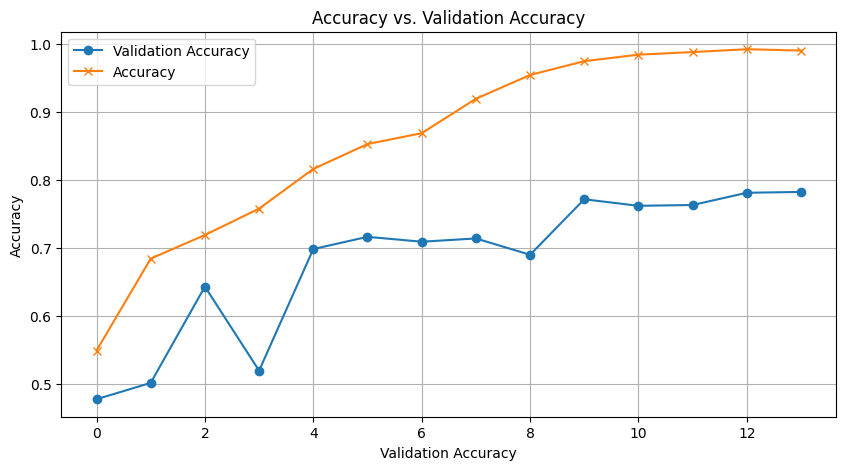

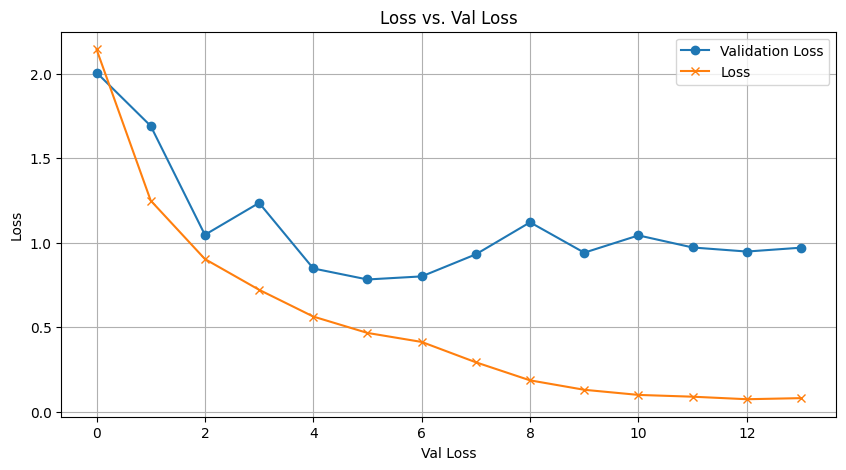

In [ ]:
import matplotlib.pyplot as plt

epochs = history.epoch
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.plot(epochs, accuracy, label='Accuracy', marker='x')
plt.title('Accuracy vs. Validation Accuracy')
plt.xlabel('Validation Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss (val_loss) and loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.plot(epochs, loss, label='Loss', marker='x')
plt.title('Loss vs. Val Loss')
plt.xlabel('Val Loss')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()